In [2]:
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import numpy as np
import os
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split


import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Conv1D, Lambda, Dropout
from tensorflow.keras.losses import Huber
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

import matplotlib as mpl
import time
from statsmodels.tsa.stattools import adfuller
from tqdm import tqdm
from PIL import Image
from statsmodels.tools.sm_exceptions import ConvergenceWarning
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

try:
    import cust_f
except:
    pass
# to perform multiprocessing using a customized function (not necessary for Linux)

tot_run_time_start = time.time()

In [6]:
warnings.simplefilter('ignore', ConvergenceWarning)
print("\nStatsmodels' ConvergenceWarning is ignored")


Statsmodels' ConvergenceWarning is ignored


In [7]:
def analysis_return(test_df):
    # ror: 일일 수익률
    # trading_rate: 거래 확률
    # success_rate: 거래 성공 확률
    # pnl_rate: 손익비
    # mdd: 최대 손실 낙폭
    # cr: 누적 수익률

    df = test_df.copy()
    df['success'] = np.where((df['ror'] > 1) & (df['trade'] == 1), 1, 0)
    df['fail'] = np.where((df['ror'] < 1) & (df['trade'] == 1), 1, 0)
    df['success_ror'] = np.where(df['success'], (df['ror'] - 1) * 100, 0)
    df['fail_ror'] = np.where(df['fail'], (1 - df['ror']) * 100, 0)

    trade_rate = df['trade'].sum() / len(df)
    success_rate = df['success'].sum() / df['trade'].sum()
    pnl_rate = df['success_ror'].sum() / df['fail_ror'].sum()
    mdd = df['mdd'].max()
    cr = df['cr'].iloc[-1]

    return_dict = {}
    return_dict['trade_rate'] = f'{trade_rate * 100: .2f}%'
    return_dict['success_rate'] = f'{success_rate * 100: .2f}%'
    return_dict['pnl_rate'] = f'{pnl_rate: .2f}'
    return_dict['mdd'] = f'{mdd: .2f}%'
    return_dict['cr'] = f'{(cr - 1) * 100: .2f}%'

    return return_dict

def backtest_ma(test_df):
    df = test_df.copy()
    df['ma5'] = df['Open'].rolling(window=5).mean()
    df['ma10'] = df['Open'].rolling(window=10).mean()
    df['ma20'] = df['Open'].rolling(window=20).mean()
    df['ma50'] = df['Open'].rolling(window=50).mean()
    df['ma100'] = df['Open'].rolling(window=100).mean()

    df['rate'] = 0
    df['rate'] = np.where(df['ma5'] < df['Open'], df['rate'] + 1, df['rate'])
    df['rate'] = np.where(df['ma10'] < df['Open'], df['rate'] + 1, df['rate'])
    df['rate'] = np.where(df['ma20'] < df['Open'], df['rate'] + 1, df['rate'])
    df['rate'] = np.where(df['ma50'] < df['Open'], df['rate'] + 1, df['rate'])
    df['rate'] = np.where(df['ma100'] < df['Open'], df['rate'] + 1, df['rate'])
    df['rate'] = df['rate'] / 5

    df['trade'] = np.where((df['Open'] < df['prediction_close']) & (df['rate'] > 0), 1, 0)
    df['ror'] = np.where(df['trade'] == 1, 1 + (df['Close'] / df['Open'] - 1) * df['rate'], 1)
    df['cr'] = df['ror'].cumprod()
    df['mdd'] = (df['cr'].cummax() - df['cr']) / df['cr'].cummax() * 100
    
    df['success'] = np.where((df['ror'] > 1) & (df['trade'] == 1), 1, 0)
    df['fail'] = np.where((df['ror'] < 1) & (df['trade'] == 1), 1, 0)
    df['success_ror'] = np.where(df['success'], (df['ror'] - 1) * 100, 0)
    df['fail_ror'] = np.where(df['fail'], (1 - df['ror']) * 100, 0)

    trade_rate = df['trade'].sum() / len(df)
    success_rate = df['success'].sum() / df['trade'].sum()
    pnl_rate = df['success_ror'].sum() / df['fail_ror'].sum()
    df['pnl_rate'] = f'{pnl_rate: .2f}'

    return df


def backtest_noise(test_df):
    noise_ma = 30
    df = test_df.copy()
    df['ma5'] = df['Open'].rolling(window=5).mean()
    df['ma10'] = df['Open'].rolling(window=10).mean()
    df['ma20'] = df['Open'].rolling(window=20).mean()
    df['ma50'] = df['Open'].rolling(window=50).mean()
    df['ma100'] = df['Open'].rolling(window=100).mean()

    df['noise'] = 1 - abs(df['Open'] - df['Close']) / ((df['High']) * (1.0000001) - df['Low'])
    df['noise'] = df['noise'].shift(1)
    df['noise_ma'] = df['noise'].rolling(window=noise_ma).mean()

    df['rate'] = 0
    df['rate'] = np.where(df['noise_ma'] < 0.3, df['rate'] + 1, df['rate'])
    df['rate'] = np.where(df['noise_ma'] < 0.4, df['rate'] + 1, df['rate'])
    df['rate'] = np.where(df['noise_ma'] < 0.5, df['rate'] + 1, df['rate'])
    df['rate'] = np.where(df['noise_ma'] < 0.6, df['rate'] + 1, df['rate'])
    df['rate'] = np.where(df['noise_ma'] < 0.7, df['rate'] + 1, df['rate'])
    df['rate'] = df['rate'] / 5

    df['trade'] = np.where((df['Open'] < df['prediction_close']) & (df['rate'] > 0), 1, 0)
    df['ror'] = np.where(df['trade'] == 1, 1 + (df['Close'] / df['Open'] - 1) * df['rate'], 1)
    df['cr'] = df['ror'].cumprod()
    df['mdd'] = (df['cr'].cummax() - df['cr']) / df['cr'].cummax() * 100
    
    df['success'] = np.where((df['ror'] > 1) & (df['trade'] == 1), 1, 0)
    df['fail'] = np.where((df['ror'] < 1) & (df['trade'] == 1), 1, 0)
    df['success_ror'] = np.where(df['success'], (df['ror'] - 1) * 100, 0)
    df['fail_ror'] = np.where(df['fail'], (1 - df['ror']) * 100, 0)

    trade_rate = df['trade'].sum() / len(df)
    success_rate = df['success'].sum() / df['trade'].sum()
    pnl_rate = df['success_ror'].sum() / df['fail_ror'].sum()
    df['pnl_rate'] = f'{pnl_rate: .2f}'

    return df


def backtest_rsi(test_df):
    df = test_df.copy()
    df['rate'] = 1
    df['up'] = np.where(df['Close'].diff(1) > 0, df['Close'].diff(1), 0)
    df['down'] = np.where(df['Close'].diff(1) < 0, df['Close'].diff(1) * (-1), 0)
    df['au'] = df['up'].rolling(window=14, min_periods=14).mean()
    df['ad'] = df['down'].rolling(window=14, min_periods=14).mean()
    df['rsi'] = df['au'].div(df['ad'] + df['au']) * 100
    df['rsi_shift_1'] = df['rsi'].shift(1) # 하루 전의 rsi
    df['trade'] = np.where((df['Open'] < df['prediction_close']) & (df['rsi_shift_1'] > 40), 1, 0)
    df['ror'] = np.where(df['trade'] == 1, df['Close'] / df['Open'], 1)
    df['cr'] = df['ror'].cumprod()
    df['mdd'] = (df['cr'].cummax() - df['cr']) / df['cr'].cummax() * 100
    
    df['success'] = np.where((df['ror'] > 1) & (df['trade'] == 1), 1, 0)
    df['fail'] = np.where((df['ror'] < 1) & (df['trade'] == 1), 1, 0)
    df['success_ror'] = np.where(df['success'], (df['ror'] - 1) * 100, 0)
    df['fail_ror'] = np.where(df['fail'], (1 - df['ror']) * 100, 0)

    trade_rate = df['trade'].sum() / len(df)
    success_rate = df['success'].sum() / df['trade'].sum()
    pnl_rate = df['success_ror'].sum() / df['fail_ror'].sum()
    df['pnl_rate'] = f'{pnl_rate: .2f}'

    return df


def backtest_ma_and_noise(test_df):
    noise_ma = 30
    df = test_df.copy()
    df['noise'] = 1 - abs(df['Open'] - df['Close']) / ((df['High']) * (1.0000001) - df['Low'])
    df['noise'] = df['noise'].shift(1)
    df['noise_ma'] = df['noise'].rolling(window=noise_ma).mean()

    df['ma5'] = df['Open'].rolling(window=5).mean()
    df['ma10'] = df['Open'].rolling(window=10).mean()
    df['ma20'] = df['Open'].rolling(window=20).mean()
    df['ma50'] = df['Open'].rolling(window=50).mean()
    df['ma100'] = df['Open'].rolling(window=100).mean()

    df['rate'] = 0
    df['rate'] = np.where(df['ma5'] < df['Open'], df['rate'] + 1, df['rate'])
    df['rate'] = np.where(df['ma10'] < df['Open'], df['rate'] + 1, df['rate'])
    df['rate'] = np.where(df['ma20'] < df['Open'], df['rate'] + 1, df['rate'])
    df['rate'] = np.where(df['ma50'] < df['Open'], df['rate'] + 1, df['rate'])
    df['rate'] = np.where(df['ma100'] < df['Open'], df['rate'] + 1, df['rate'])
    df['rate'] = np.where(df['noise_ma'] < 0.3, df['rate'] + 1, df['rate'])
    df['rate'] = np.where(df['noise_ma'] < 0.4, df['rate'] + 1, df['rate'])
    df['rate'] = np.where(df['noise_ma'] < 0.5, df['rate'] + 1, df['rate'])
    df['rate'] = np.where(df['noise_ma'] < 0.6, df['rate'] + 1, df['rate'])
    df['rate'] = np.where(df['noise_ma'] < 0.7, df['rate'] + 1, df['rate'])
    df['rate'] = df['rate'] / 10

    df['trade'] = np.where((df['Open'] < df['prediction_close']) & (df['rate'] > 0), 1, 0)
    df['ror'] = np.where(df['trade'] == 1, 1 + (df['Close'] / df['Open'] - 1) * df['rate'], 1)
    df['cr'] = df['ror'].cumprod()
    df['mdd'] = (df['cr'].cummax() - df['cr']) / df['cr'].cummax() * 100
    
    df['success'] = np.where((df['ror'] > 1) & (df['trade'] == 1), 1, 0)
    df['fail'] = np.where((df['ror'] < 1) & (df['trade'] == 1), 1, 0)
    df['success_ror'] = np.where(df['success'], (df['ror'] - 1) * 100, 0)
    df['fail_ror'] = np.where(df['fail'], (1 - df['ror']) * 100, 0)

    trade_rate = df['trade'].sum() / len(df)
    success_rate = df['success'].sum() / df['trade'].sum()
    pnl_rate = df['success_ror'].sum() / df['fail_ror'].sum()
    df['pnl_rate'] = f'{pnl_rate: .2f}'

    return df


def backtest_ma_and_rsi(test_df):
    df = test_df.copy()
    df['up'] = np.where(df['Close'].diff(1) > 0, df['Close'].diff(1), 0)
    df['down'] = np.where(df['Close'].diff(1) < 0, df['Close'].diff(1) * (-1), 0)
    df['au'] = df['up'].rolling(window=14, min_periods=14).mean()
    df['ad'] = df['down'].rolling(window=14, min_periods=14).mean()
    df['rsi'] = df['au'].div(df['ad'] + df['au']) * 100
    df['rsi_shift_1'] = df['rsi'].shift(1) # 하루 전의 rsi

    df['ma5'] = df['Open'].rolling(window=5).mean()
    df['ma10'] = df['Open'].rolling(window=10).mean()
    df['ma20'] = df['Open'].rolling(window=20).mean()
    df['ma50'] = df['Open'].rolling(window=50).mean()
    df['ma100'] = df['Open'].rolling(window=100).mean()

    df['rate'] = 0
    df['rate'] = np.where(df['ma5'] < df['Open'], df['rate'] + 1, df['rate'])
    df['rate'] = np.where(df['ma10'] < df['Open'], df['rate'] + 1, df['rate'])
    df['rate'] = np.where(df['ma20'] < df['Open'], df['rate'] + 1, df['rate'])
    df['rate'] = np.where(df['ma50'] < df['Open'], df['rate'] + 1, df['rate'])
    df['rate'] = np.where(df['ma100'] < df['Open'], df['rate'] + 1, df['rate'])
    df['rate'] = df['rate'] / 5

    df['trade'] = np.where((df['Open'] < df['prediction_close']) & (df['rate'] > 0) & (df['rsi_shift_1'] > 40), 1, 0)  # rsi가 40이상일 경우에만 거래 진행
    df['ror'] = np.where(df['trade'] == 1, 1 + (df['Close'] / df['Open'] - 1) * df['rate'], 1)
    df['cr'] = df['ror'].cumprod()
    df['mdd'] = (df['cr'].cummax() - df['cr']) / df['cr'].cummax() * 100

    df['success'] = np.where((df['ror'] > 1) & (df['trade'] == 1), 1, 0)
    df['fail'] = np.where((df['ror'] < 1) & (df['trade'] == 1), 1, 0)
    df['success_ror'] = np.where(df['success'], (df['ror'] - 1) * 100, 0)
    df['fail_ror'] = np.where(df['fail'], (1 - df['ror']) * 100, 0)

    trade_rate = df['trade'].sum() / len(df)
    success_rate = df['success'].sum() / df['trade'].sum()
    pnl_rate = df['success_ror'].sum() / df['fail_ror'].sum()
    df['pnl_rate'] = f'{pnl_rate: .2f}'

    return df


def backtest_noise_and_rsi(test_df):
    df = test_df.copy()
    noise_ma = 30
    df['noise'] = 1 - abs(df['Open'] - df['Close']) / ((df['High']) * (1.0000001) - df['Low'])
    df['noise'] = df['noise'].shift(1)
    df['noise_ma'] = df['noise'].rolling(window=noise_ma).mean()
    df['up'] = np.where(df['Close'].diff(1) > 0, df['Close'].diff(1), 0)
    df['down'] = np.where(df['Close'].diff(1) < 0, df['Close'].diff(1) * (-1), 0)
    df['au'] = df['up'].rolling(window=14, min_periods=14).mean()
    df['ad'] = df['down'].rolling(window=14, min_periods=14).mean()
    df['rsi'] = df['au'].div(df['ad'] + df['au']) * 100
    df['rsi_shift_1'] = df['rsi'].shift(1) # 하루 전의 rsi

    df['rate'] = 0
    df['rate'] = np.where(df['noise_ma'] < 0.3, df['rate'] + 1, df['rate'])
    df['rate'] = np.where(df['noise_ma'] < 0.4, df['rate'] + 1, df['rate'])
    df['rate'] = np.where(df['noise_ma'] < 0.5, df['rate'] + 1, df['rate'])
    df['rate'] = np.where(df['noise_ma'] < 0.6, df['rate'] + 1, df['rate'])
    df['rate'] = np.where(df['noise_ma'] < 0.7, df['rate'] + 1, df['rate'])
    df['rate'] = df['rate'] / 5

    df['trade'] = np.where((df['Open'] < df['prediction_close']) & (df['rate'] > 0) & (df['rsi_shift_1'] > 40), 1, 0)  # rsi가 40이상일 경우에만 거래 진행
    df['ror'] = np.where(df['trade'] == 1, 1 + (df['Close'] / df['Open'] - 1) * df['rate'], 1)
    df['cr'] = df['ror'].cumprod()
    df['mdd'] = (df['cr'].cummax() - df['cr']) / df['cr'].cummax() * 100

    df['success'] = np.where((df['ror'] > 1) & (df['trade'] == 1), 1, 0)
    df['fail'] = np.where((df['ror'] < 1) & (df['trade'] == 1), 1, 0)
    df['success_ror'] = np.where(df['success'], (df['ror'] - 1) * 100, 0)
    df['fail_ror'] = np.where(df['fail'], (1 - df['ror']) * 100, 0)

    trade_rate = df['trade'].sum() / len(df)
    success_rate = df['success'].sum() / df['trade'].sum()
    pnl_rate = df['success_ror'].sum() / df['fail_ror'].sum()
    df['pnl_rate'] = f'{pnl_rate: .2f}'

    return df


def backtest_ma_and_rsi_and_noise(test_df):
    noise_ma = 30
    df = test_df.copy()
    df['up'] = np.where(df['Close'].diff(1) > 0, df['Close'].diff(1), 0)
    df['down'] = np.where(df['Close'].diff(1) < 0, df['Close'].diff(1) * (-1), 0)
    df['au'] = df['up'].rolling(window=14, min_periods=14).mean()
    df['ad'] = df['down'].rolling(window=14, min_periods=14).mean()
    df['rsi'] = df['au'].div(df['ad'] + df['au']) * 100
    df['rsi_shift_1'] = df['rsi'].shift(1) # 하루 전의 rsi

    df['noise'] = 1 - abs(df['Open'] - df['Close']) / ((df['High']) * (1.0000001) - df['Low'])
    df['noise'] = df['noise'].shift(1)
    df['noise_ma'] = df['noise'].rolling(window=noise_ma).mean()
    df['ma5'] = df['Open'].rolling(window=5).mean()
    df['ma10'] = df['Open'].rolling(window=10).mean()
    df['ma20'] = df['Open'].rolling(window=20).mean()
    df['ma50'] = df['Open'].rolling(window=50).mean()
    df['ma100'] = df['Open'].rolling(window=100).mean()

    df['rate'] = 0
    df['rate'] = np.where(df['ma5'] < df['Open'], df['rate'] + 1, df['rate'])
    df['rate'] = np.where(df['ma10'] < df['Open'], df['rate'] + 1, df['rate'])
    df['rate'] = np.where(df['ma20'] < df['Open'], df['rate'] + 1, df['rate'])
    df['rate'] = np.where(df['ma50'] < df['Open'], df['rate'] + 1, df['rate'])
    df['rate'] = np.where(df['ma100'] < df['Open'], df['rate'] + 1, df['rate'])
    df['rate'] = np.where(df['noise_ma'] < 0.3, df['rate'] + 1, df['rate'])
    df['rate'] = np.where(df['noise_ma'] < 0.4, df['rate'] + 1, df['rate'])
    df['rate'] = np.where(df['noise_ma'] < 0.5, df['rate'] + 1, df['rate'])
    df['rate'] = np.where(df['noise_ma'] < 0.6, df['rate'] + 1, df['rate'])
    df['rate'] = np.where(df['noise_ma'] < 0.7, df['rate'] + 1, df['rate'])
    df['rate'] = df['rate'] / 10

    df['trade'] = np.where((df['Open'] < df['prediction_close']) & (df['rate'] > 0) & (df['rsi_shift_1'] > 40), 1, 0)  # rsi가 40이상일 경우에만 거래 진행
    df['ror'] = np.where(df['trade'] == 1, 1 + (df['Close'] / df['Open'] - 1) * df['rate'], 1)
    df['cr'] = df['ror'].cumprod()
    df['mdd'] = (df['cr'].cummax() - df['cr']) / df['cr'].cummax() * 100

    df['success'] = np.where((df['ror'] > 1) & (df['trade'] == 1), 1, 0)
    df['fail'] = np.where((df['ror'] < 1) & (df['trade'] == 1), 1, 0)
    df['success_ror'] = np.where(df['success'], (df['ror'] - 1) * 100, 0)
    df['fail_ror'] = np.where(df['fail'], (1 - df['ror']) * 100, 0)

    trade_rate = df['trade'].sum() / len(df)
    success_rate = df['success'].sum() / df['trade'].sum()
    pnl_rate = df['success_ror'].sum() / df['fail_ror'].sum()
    df['pnl_rate'] = f'{pnl_rate: .2f}'

    return df

def plot_result(df):
    plt.figure(figsize=(20, 8))
    plt.plot(df.index, df['Close'].values, color='b', label='real close')
    plt.plot(df.index, df['prediction_close'].values , color='r', label='prediction close')
    plt.legend()
    plt.grid(True)
    plt.show()

def plot_return(df):
    plt.figure(figsize=(20, 8))
    plt.plot(df.index, df['cr'].values , color='r', label='return')
    plt.legend()
    plt.title(
        f"mdd: {round(df['mdd'].max(), 2)}\nreturn_rate: {round(df['cr'].iloc[-1] * 100 - 100, 2)}%")
    plt.grid(True)
    plt.show()

In [8]:
def batch(iterable, batch_size, pt):
    """
    batch row 생성 이터레이터
    Args:
        iterable: iterable datastructure
        batch_size:
        pt: prediction term 예측 기간
    Returns:
        yield: batch row
    """

    l = len(iterable)
    for idx, ndx in tqdm(enumerate(range(0, l, pt))):
        yield idx, iterable[ndx: min(ndx + batch_size, l)]

        
def seq2dataset(df,window,horizon):
    X=[]; Y=[]
    
    x_val, y_val = df.drop('Close',axis=1,inplace=False),df['Close']
    x_val = x_val.to_numpy()
    y_val = y_val.to_numpy()
    
    for i in range(0, len(df)-(window+horizon)+1, 5):
        x=x_val[i:(i+window)]
        y=y_val[i+window+horizon-1]
        X.append(x); Y.append(y)
    return np.array(X), np.array(Y)

        
def backtest_lstm_1d(test_df: pd.DataFrame, ft: int, pt: int, plot=True) -> pd.DataFrame:
    """

    Args:
        test_df: 1일 봉 데이터
        ft: fitting term 피팅 시킬 기간
        pt: prediction term 예측 기간
        arima_params:
    Returns:
        df: 예측 값이 열로 포함된 DataFrame
    """
    df = test_df.copy()
    df = df.drop('Datetime',axis=1,inplace=False)
    
    scaler = MinMaxScaler()

    # 스케일 후 columns
    df = pd.DataFrame(scaler.fit_transform(df[:]),columns=df.columns, index=list(df.index.values))
    
    batch_size = ft + pt
    total_loop = int(len(df) / pt) - 1
    result_columns = list(df.columns)
    result_columns.append("prediction_close")

    result_df = pd.DataFrame(columns=result_columns)

    try:
        for idx, batch_df in batch(df, batch_size, pt):
            # 윈도우 w와 수평선 h

            w = 10   # 윈도우는 이전 요소 몇 개를 볼 것인지
            h = 1    # 수평선은 얼마나 먼 미래를 예측할 것인지
            
            train, test = batch_df[:ft-1], batch_df[ft-w:ft]
            X_train, y_train = seq2dataset(train, w, h)
            
            
            #X_train = X_train.reshape((len(X_train), 1, 4))
            #y_train = y_train.reshape((len(y_train), 1, 1))
            
            X_test, y_test = test.drop('Close',axis=1,inplace=False),test['Close']
            X_test = X_test.to_numpy()
            y_test = y_test.to_numpy()
            
            X_test = X_test.reshape(pt, w, 4)
            y_test = y_test.reshape(pt, w, 1)

            # LSTM 모델 구축
            model = Sequential()
            model.add(LSTM(units=256,activation='tanh',input_shape=X_train[0].shape))
            model.add(Dropout(0.2))
            model.add(Dense(1))
            
            # Sequence 학습에 비교적 좋은 퍼포먼스를 내는 Huber()를 사용한다.
            loss = Huber()
            optimizer = Adam(0.0005)
            model.compile(loss=Huber(), optimizer=optimizer, metrics=['mse'])
            
            # earlystopping은 10번 epoch통안 val_loss 개선이 없다면 학습을 멈춘다.
            earlystopping = EarlyStopping(monitor='val_loss', patience=10)
            # val_loss 기준 체크포인터도 생성한다.
                        
            model.fit(X_train,y_train,epochs=100,batch_size=16,validation_split=0.3,callbacks=[earlystopping], verbose=0)  
            
            # 예측
            pred = model.predict(X_test)
            
            if len(pred) ==0:
                break
            row = batch_df.iloc[[-1]]
            row['prediction_close'] = pred
            row['batch_open'] = batch_df.iloc[ft].Open
            result_df = pd.concat([result_df, row], axis=0)

    except IndexError:
        pass
    result_df['trade'] = np.where(result_df['batch_open'] < result_df['prediction_close'], 1, 0)
    result_df['ror'] = np.where(result_df['trade'] == 1, result_df['Close'] / result_df['batch_open'], 1)
    result_df['cr'] = result_df['ror'].cumprod()
    result_df['mdd'] = (result_df['cr'].cummax() - result_df['cr']) / result_df['cr'].cummax() * 100

    if plot:
        plot_result(result_df)
        plot_return(result_df)

    return result_df

In [3]:
with open("../../data/btc_usd_1d.pkl", "rb") as f:
    df=pickle.load(f)
    #df=df.reset_index()
    #df.rename({'ot':'Date'},axis=1,inplace=True)

In [ ]:
analysis_return(result_df)

4it [00:45, 11.83s/it]

5it [00:53, 10.47s/it]

1862it [3:49:30,  7.40s/it]


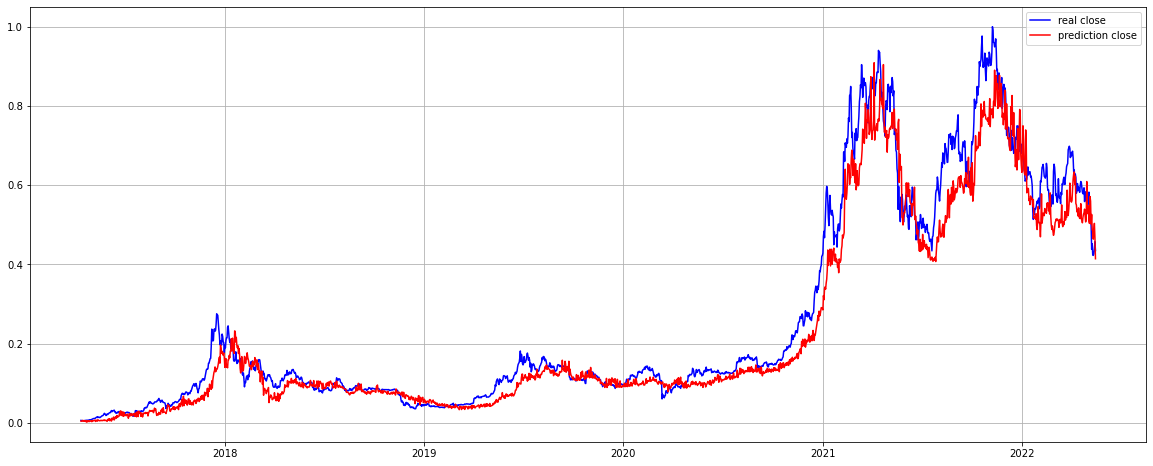

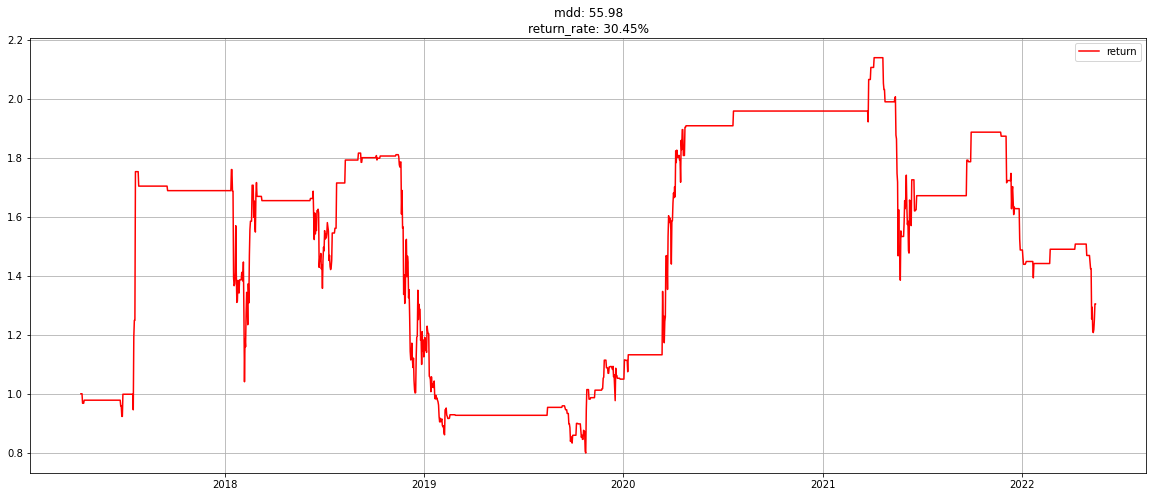

In [8]:
result_df = backtest_lstm_1d(df, 100, 1)

In [9]:
#result_df.to_csv("0618_1d_2017_LSTM.csv")

In [56]:
result_df = pd.read_csv("../LSTM/0618_1d_2017_LSTM.csv")

In [57]:
result_df

,Unnamed: 0,Open,High,Low,Close,Volume,prediction_close,batch_open,trade,ror,cr,mdd
0,2017-04-11,0.006448,0.005949,0.006820,0.006443,0.005477,0.004729,0.006448,0,1.000000,1.000000,0.000000
1,2017-04-12,0.006594,0.005884,0.006972,0.006341,0.005470,0.004347,0.006594,0,1.000000,1.000000,0.000000
2,2017-04-13,0.006492,0.005808,0.005949,0.005753,0.010890,0.004654,0.006492,0,1.000000,1.000000,0.000000
3,2017-04-14,0.005904,0.005420,0.005964,0.005714,0.013564,0.006457,0.005904,1,0.967814,0.967814,3.218589
4,2017-04-15,0.005866,0.005413,0.006316,0.005761,0.002755,0.005831,0.005866,0,1.000000,0.967814,3.218589
...,...,...,...,...,...,...,...,...,...,...,...,...
1857,2022-05-12,0.423839,0.431725,0.395117,0.422822,0.001249,0.463935,0.423839,1,0.997601,1.207405,43.548336
1858,2022-05-13,0.422984,0.443688,0.427170,0.426620,0.000657,0.488213,0.422984,1,1.008597,1.217784,43.063030
1859,2022-05-14,0.426779,0.433122,0.425214,0.438684,0.000409,0.503668,0.426779,1,1.027895,1.251754,41.474785
1860,2022-05-15,0.438840,0.449400,0.438126,0.457324,0.000436,0.468504,0.438840,1,1.042120,1.304478,39.009703


In [58]:
result_df['Datetime'] = result_df['Unnamed: 0']
result_df.set_index('Unnamed: 0', inplace = True)
result_df.index.name = None
result_df['Datetime'] = pd.to_datetime(result_df['Datetime'])
result_df.index = pd.to_datetime(result_df.index)

In [60]:
result_df

,Open,High,Low,Close,Volume,prediction_close,batch_open,trade,ror,cr,mdd,Datetime
2017-04-11,0.006448,0.005949,0.006820,0.006443,0.005477,0.004729,0.006448,0,1.000000,1.000000,0.000000,2017-04-11
2017-04-12,0.006594,0.005884,0.006972,0.006341,0.005470,0.004347,0.006594,0,1.000000,1.000000,0.000000,2017-04-12
2017-04-13,0.006492,0.005808,0.005949,0.005753,0.010890,0.004654,0.006492,0,1.000000,1.000000,0.000000,2017-04-13
2017-04-14,0.005904,0.005420,0.005964,0.005714,0.013564,0.006457,0.005904,1,0.967814,0.967814,3.218589,2017-04-14
2017-04-15,0.005866,0.005413,0.006316,0.005761,0.002755,0.005831,0.005866,0,1.000000,0.967814,3.218589,2017-04-15
...,...,...,...,...,...,...,...,...,...,...,...,...
2022-05-12,0.423839,0.431725,0.395117,0.422822,0.001249,0.463935,0.423839,1,0.997601,1.207405,43.548336,2022-05-12
2022-05-13,0.422984,0.443688,0.427170,0.426620,0.000657,0.488213,0.422984,1,1.008597,1.217784,43.063030,2022-05-13
2022-05-14,0.426779,0.433122,0.425214,0.438684,0.000409,0.503668,0.426779,1,1.027895,1.251754,41.474785,2022-05-14
2022-05-15,0.438840,0.449400,0.438126,0.457324,0.000436,0.468504,0.438840,1,1.042120,1.304478,39.009703,2022-05-15


In [61]:
from datetime import datetime

import numpy as np


def create_csv_using_only_model(result_df, model_name):
    """
    100일 통합 결과
    Args:
        result_df: df - 백테스트 완료 테이블
        model_name: arima
    Returns:
        csv 파일
    """
    df = result_df.copy()

    df["partition"] = ""
    df["partition"] = np.where((df["Datetime"] >= datetime(year=2021, month=5, day=10)) & (df["Datetime"] <= datetime(year=2021, month=7, day=21)), "loss1", df["partition"])
    df["partition"] = np.where((df["Datetime"] >= datetime(year=2021, month=11, day=18)) & (df["Datetime"] <= datetime(year=2022, month=2, day=6)), "loss2", df["partition"])
    df["partition"] = np.where((df["Datetime"] >= datetime(year=2019, month=2, day=17)) & (df["Datetime"] <= datetime(year=2019, month=7, day=15)), "profit1", df["partition"])
    df["partition"] = np.where((df["Datetime"] >= datetime(year=2020, month=10, day=8)) & (df["Datetime"] <= datetime(year=2021, month=4, day=17)), "profit2", df["partition"])

    condition = "ma"
    temp_df = backtest_ma(df)[["ror", "cr", "mdd", "rate"]]
    df[f"{condition}+return_of_rate"] = temp_df["ror"]
    df[f"{condition}+cumulative_return_of_rate"] = temp_df["cr"]
    df[f"{condition}+mdd"] = temp_df["mdd"]
    df[f"{condition}+rate"] = temp_df["rate"]

    condition = "rsi"
    temp_df = backtest_rsi(df)[["ror", "cr", "mdd", "rate"]]
    df[f"{condition}+return_of_rate"] = temp_df["ror"]
    df[f"{condition}+cumulative_return_of_rate"] = temp_df["cr"]
    df[f"{condition}+mdd"] = temp_df["mdd"]
    df[f"{condition}+rate"] = temp_df["rate"]

    condition = "noise"
    temp_df = backtest_noise(df)[["ror", "cr", "mdd", "rate"]]
    df[f"{condition}+return_of_rate"] = temp_df["ror"]
    df[f"{condition}+cumulative_return_of_rate"] = temp_df["cr"]
    df[f"{condition}+mdd"] = temp_df["mdd"]
    df[f"{condition}+rate"] = temp_df["rate"]

    condition = "ma_noise"
    temp_df = backtest_ma_and_noise(df)[["ror", "cr", "mdd", "rate"]]
    df[f"{condition}+return_of_rate"] = temp_df["ror"]
    df[f"{condition}+cumulative_return_of_rate"] = temp_df["cr"]
    df[f"{condition}+mdd"] = temp_df["mdd"]
    df[f"{condition}+rate"] = temp_df["rate"]

    condition = "ma_rsi"
    temp_df = backtest_ma_and_rsi(df)[["ror", "cr", "mdd", "rate"]]
    df[f"{condition}+return_of_rate"] = temp_df["ror"]
    df[f"{condition}+cumulative_return_of_rate"] = temp_df["cr"]
    df[f"{condition}+mdd"] = temp_df["mdd"]
    df[f"{condition}+rate"] = temp_df["rate"]

    condition = "rsi_noise"
    temp_df = backtest_noise_and_rsi(df)[["ror", "cr", "mdd", "rate"]]
    df[f"{condition}+return_of_rate"] = temp_df["ror"]
    df[f"{condition}+cumulative_return_of_rate"] = temp_df["cr"]
    df[f"{condition}+mdd"] = temp_df["mdd"]
    df[f"{condition}+rate"] = temp_df["rate"]

    condition = "ma_rsi_noise"
    temp_df = backtest_ma_and_rsi_and_noise(df)[["ror", "cr", "mdd", "rate"]]
    df[f"{condition}+return_of_rate"] = temp_df["ror"]
    df[f"{condition}+cumulative_return_of_rate"] = temp_df["cr"]
    df[f"{condition}+mdd"] = temp_df["mdd"]
    df[f"{condition}+rate"] = temp_df["rate"]

    df.rename(columns={"ror": "return of rate", "cr": "cumulative return of rate"}, inplace=True)
    file_name = f"only_{model_name}.csv"
    df.to_csv(file_name)

    return df

def create_csv_using_only_best_model(result_df, model_name, fitting_term):
    """
    최고 성능 모델
    Args:
        result_df: df - 백테스트 완료 테이블
        model_name: arima
        fitting_term: 100 - 학습 일 수
    Returns:
        csv 파일
    """
    df = result_df.copy()
    df["partition"] = ""
    df["partition"] = np.where((df["Datetime"] >= datetime(year=2021, month=5, day=10)) & (df["Datetime"] <= datetime(year=2021, month=7, day=21)), "loss1", df["partition"])
    df["partition"] = np.where((df["Datetime"] >= datetime(year=2021, month=11, day=18)) & (df["Datetime"] <= datetime(year=2022, month=2, day=6)), "loss2", df["partition"])
    df["partition"] = np.where((df["Datetime"] >= datetime(year=2019, month=2, day=17)) & (df["Datetime"] <= datetime(year=2019, month=7, day=15)), "profit1", df["partition"])
    df["partition"] = np.where((df["Datetime"] >= datetime(year=2020, month=10, day=8)) & (df["Datetime"] <= datetime(year=2021, month=4, day=17)), "profit2", df["partition"])

    condition = "ma"
    temp_df = backtest_ma(df)[["ror", "cr", "mdd", "rate"]]
    df[f"{condition}+return_of_rate"] = temp_df["ror"]
    df[f"{condition}+cumulative_return_of_rate"] = temp_df["cr"]
    df[f"{condition}+mdd"] = temp_df["mdd"]
    df[f"{condition}+rate"] = temp_df["rate"]

    condition = "rsi"
    temp_df = backtest_rsi(df)[["ror", "cr", "mdd", "rate"]]
    df[f"{condition}+return_of_rate"] = temp_df["ror"]
    df[f"{condition}+cumulative_return_of_rate"] = temp_df["cr"]
    df[f"{condition}+mdd"] = temp_df["mdd"]
    df[f"{condition}+rate"] = temp_df["rate"]

    condition = "noise"
    temp_df = backtest_noise(df)[["ror", "cr", "mdd", "rate"]]
    df[f"{condition}+return_of_rate"] = temp_df["ror"]
    df[f"{condition}+cumulative_return_of_rate"] = temp_df["cr"]
    df[f"{condition}+mdd"] = temp_df["mdd"]
    df[f"{condition}+rate"] = temp_df["rate"]

    condition = "ma_noise"
    temp_df = backtest_ma_and_noise(df)[["ror", "cr", "mdd", "rate"]]
    df[f"{condition}+return_of_rate"] = temp_df["ror"]
    df[f"{condition}+cumulative_return_of_rate"] = temp_df["cr"]
    df[f"{condition}+mdd"] = temp_df["mdd"]
    df[f"{condition}+rate"] = temp_df["rate"]

    condition = "ma_rsi"
    temp_df = backtest_ma_and_rsi(df)[["ror", "cr", "mdd", "rate"]]
    df[f"{condition}+return_of_rate"] = temp_df["ror"]
    df[f"{condition}+cumulative_return_of_rate"] = temp_df["cr"]
    df[f"{condition}+mdd"] = temp_df["mdd"]
    df[f"{condition}+rate"] = temp_df["rate"]

    condition = "rsi_noise"
    temp_df = backtest_noise_and_rsi(df)[["ror", "cr", "mdd", "rate"]]
    df[f"{condition}+return_of_rate"] = temp_df["ror"]
    df[f"{condition}+cumulative_return_of_rate"] = temp_df["cr"]
    df[f"{condition}+mdd"] = temp_df["mdd"]
    df[f"{condition}+rate"] = temp_df["rate"]

    condition = "ma_rsi_noise"
    temp_df = backtest_ma_and_rsi_and_noise(df)[["ror", "cr", "mdd", "rate"]]
    df[f"{condition}+return_of_rate"] = temp_df["ror"]
    df[f"{condition}+cumulative_return_of_rate"] = temp_df["cr"]
    df[f"{condition}+mdd"] = temp_df["mdd"]
    df[f"{condition}+rate"] = temp_df["rate"]
    df.rename(columns={"ror": "return_of_rate", "cr": "cumulative_return_of_rate"}, inplace=True)

    file_name = f"only_best_{model_name}_{fitting_term}.csv"
    df.to_csv(file_name)
    return df


def get_extracted_df_from_total_df(test_df, condition_list=[], partition=None):
    """
    Args:
        test_df:
        condition_list: ["ma"], ["ma", "noise"], ["ma", "noise", "rsi"]
        partition: profit1, profit2, loss1, loss2
    Returns:
        df
    """
    condition = ""

    if len(condition_list) == 0:
        condition = ""

    elif len(condition_list) == 1:
        if "rsi" in condition_list:
            condition = "rsi"
        elif "ma" in condition_list:
            condition = "ma"
        elif "noise" in condition_list:
            condition = "noise"

    elif len(condition_list) == 2:
        if "rsi" in condition_list and "ma" in condition_list:
            condition = "ma_rsi"
        elif "rsi" in condition_list and "noise" in condition_list:
            condition = "rsi_noise"
        elif "noise" in condition_list and "ma" in condition_list:
            condition = "ma_noise"


    elif len(condition_list) == 3:
        condition = "ma_rsi_noise"


    if len(condition):
        columns = ["Datetime", "Close", "partition", "prediction_close", f"{condition}+return_of_rate", f"{condition}+cumulative_return_of_rate", f"{condition}+mdd", f"{condition}+rate" ]
    else:
        columns = ["Datetime", "Close", "partition", "prediction_close", "return_of_rate", "cumulative_return_of_rate", "mdd", "rate" ]

    df = test_df[columns]
    columns = list(map(lambda x:x.split("+")[-1], columns))
    df.columns = columns

    if partition == "profit1":
        df = df[df["partition"] == "profit1"]
    elif partition == "profit2":
        df = df[df["partition"] == "profit2"]
    elif partition == "loss1":
        df = df[df["partition"] == "loss1"]
    elif partition == "loss2":
        df = df[df["partition"] == "loss2"]

    df['cumulative_return_of_rate'] = df['return_of_rate'].cumprod()
    df['mdd'] = (df['cumulative_return_of_rate'].cummax() - df['cumulative_return_of_rate']) / df['cumulative_return_of_rate'].cummax() * 100

    return df


def backtest_ma(test_df):
    df = test_df.copy()
    df['ma5'] = df['Open'].rolling(window=5).mean()
    df['ma10'] = df['Open'].rolling(window=10).mean()
    df['ma20'] = df['Open'].rolling(window=20).mean()
    df['ma50'] = df['Open'].rolling(window=50).mean()
    df['ma100'] = df['Open'].rolling(window=100).mean()

    df['rate'] = 0
    df['rate'] = np.where(df['ma5'] < df['Open'], df['rate'] + 1, df['rate'])
    df['rate'] = np.where(df['ma10'] < df['Open'], df['rate'] + 1, df['rate'])
    df['rate'] = np.where(df['ma20'] < df['Open'], df['rate'] + 1, df['rate'])
    df['rate'] = np.where(df['ma50'] < df['Open'], df['rate'] + 1, df['rate'])
    df['rate'] = np.where(df['ma100'] < df['Open'], df['rate'] + 1, df['rate'])
    df['rate'] = df['rate'] / 5

    df['trade'] = np.where((df['Open'] < df['prediction_close']) & (df['rate'] > 0), 1, 0)
    df['ror'] = np.where(df['trade'] == 1, 1 + (df['Close'] / df['Open'] - 1) * df['rate'], 1)
    df['cr'] = df['ror'].cumprod()
    df['mdd'] = (df['cr'].cummax() - df['cr']) / df['cr'].cummax() * 100
    return df


def backtest_noise(test_df):
    noise_ma = 30
    df = test_df.copy()
    df['ma5'] = df['Open'].rolling(window=5).mean()
    df['ma10'] = df['Open'].rolling(window=10).mean()
    df['ma20'] = df['Open'].rolling(window=20).mean()
    df['ma50'] = df['Open'].rolling(window=50).mean()
    df['ma100'] = df['Open'].rolling(window=100).mean()

    df['noise'] = 1 - abs(df['Open'] - df['Close']) / ((df['High']) * (1.0000001) - df['Low'])
    df['noise'] = df['noise'].shift(1)
    df['noise_ma'] = df['noise'].rolling(window=noise_ma).mean()

    df['rate'] = 0
    df['rate'] = np.where(df['noise_ma'] < 0.3, df['rate'] + 1, df['rate'])
    df['rate'] = np.where(df['noise_ma'] < 0.4, df['rate'] + 1, df['rate'])
    df['rate'] = np.where(df['noise_ma'] < 0.5, df['rate'] + 1, df['rate'])
    df['rate'] = np.where(df['noise_ma'] < 0.6, df['rate'] + 1, df['rate'])
    df['rate'] = np.where(df['noise_ma'] < 0.7, df['rate'] + 1, df['rate'])
    df['rate'] = df['rate'] / 5

    df['trade'] = np.where((df['Open'] < df['prediction_close']) & (df['rate'] > 0), 1, 0)
    df['ror'] = np.where(df['trade'] == 1, 1 + (df['Close'] / df['Open'] - 1) * df['rate'], 1)
    df['cr'] = df['ror'].cumprod()
    df['mdd'] = (df['cr'].cummax() - df['cr']) / df['cr'].cummax() * 100
    return df


def backtest_rsi(test_df):
    df = test_df.copy()
    df['rate'] = 1
    df['up'] = np.where(df['Close'].diff(1) > 0, df['Close'].diff(1), 0)
    df['down'] = np.where(df['Close'].diff(1) < 0, df['Close'].diff(1) * (-1), 0)
    df['au'] = df['up'].rolling(window=14, min_periods=14).mean()
    df['ad'] = df['down'].rolling(window=14, min_periods=14).mean()
    df['rsi'] = df['au'].div(df['ad'] + df['au']) * 100
    df['rsi_shift_1'] = df['rsi'].shift(1) # 하루 전의 rsi
    df['trade'] = np.where((df['Open'] < df['prediction_close']) & (df['rsi_shift_1'] > 40), 1, 0)
    df['ror'] = np.where(df['trade'] == 1, df['Close'] / df['Open'], 1)
    df['cr'] = df['ror'].cumprod()
    df['mdd'] = (df['cr'].cummax() - df['cr']) / df['cr'].cummax() * 100
    return df


def backtest_ma_and_noise(test_df):
    noise_ma = 30
    df = test_df.copy()
    df['noise'] = 1 - abs(df['Open'] - df['Close']) / ((df['High']) * (1.0000001) - df['Low'])
    df['noise'] = df['noise'].shift(1)
    df['noise_ma'] = df['noise'].rolling(window=noise_ma).mean()

    df['ma5'] = df['Open'].rolling(window=5).mean()
    df['ma10'] = df['Open'].rolling(window=10).mean()
    df['ma20'] = df['Open'].rolling(window=20).mean()
    df['ma50'] = df['Open'].rolling(window=50).mean()
    df['ma100'] = df['Open'].rolling(window=100).mean()

    df['rate'] = 0
    df['rate'] = np.where(df['ma5'] < df['Open'], df['rate'] + 1, df['rate'])
    df['rate'] = np.where(df['ma10'] < df['Open'], df['rate'] + 1, df['rate'])
    df['rate'] = np.where(df['ma20'] < df['Open'], df['rate'] + 1, df['rate'])
    df['rate'] = np.where(df['ma50'] < df['Open'], df['rate'] + 1, df['rate'])
    df['rate'] = np.where(df['ma100'] < df['Open'], df['rate'] + 1, df['rate'])
    df['rate'] = np.where(df['noise_ma'] < 0.3, df['rate'] + 1, df['rate'])
    df['rate'] = np.where(df['noise_ma'] < 0.4, df['rate'] + 1, df['rate'])
    df['rate'] = np.where(df['noise_ma'] < 0.5, df['rate'] + 1, df['rate'])
    df['rate'] = np.where(df['noise_ma'] < 0.6, df['rate'] + 1, df['rate'])
    df['rate'] = np.where(df['noise_ma'] < 0.7, df['rate'] + 1, df['rate'])
    df['rate'] = df['rate'] / 10

    df['trade'] = np.where((df['Open'] < df['prediction_close']) & (df['rate'] > 0), 1, 0)
    df['ror'] = np.where(df['trade'] == 1, 1 + (df['Close'] / df['Open'] - 1) * df['rate'], 1)
    df['cr'] = df['ror'].cumprod()
    df['mdd'] = (df['cr'].cummax() - df['cr']) / df['cr'].cummax() * 100
    return df


def backtest_ma_and_rsi(test_df):
    df = test_df.copy()
    df['up'] = np.where(df['Close'].diff(1) > 0, df['Close'].diff(1), 0)
    df['down'] = np.where(df['Close'].diff(1) < 0, df['Close'].diff(1) * (-1), 0)
    df['au'] = df['up'].rolling(window=14, min_periods=14).mean()
    df['ad'] = df['down'].rolling(window=14, min_periods=14).mean()
    df['rsi'] = df['au'].div(df['ad'] + df['au']) * 100
    df['rsi_shift_1'] = df['rsi'].shift(1) # 하루 전의 rsi

    df['ma5'] = df['Open'].rolling(window=5).mean()
    df['ma10'] = df['Open'].rolling(window=10).mean()
    df['ma20'] = df['Open'].rolling(window=20).mean()
    df['ma50'] = df['Open'].rolling(window=50).mean()
    df['ma100'] = df['Open'].rolling(window=100).mean()

    df['rate'] = 0
    df['rate'] = np.where(df['ma5'] < df['Open'], df['rate'] + 1, df['rate'])
    df['rate'] = np.where(df['ma10'] < df['Open'], df['rate'] + 1, df['rate'])
    df['rate'] = np.where(df['ma20'] < df['Open'], df['rate'] + 1, df['rate'])
    df['rate'] = np.where(df['ma50'] < df['Open'], df['rate'] + 1, df['rate'])
    df['rate'] = np.where(df['ma100'] < df['Open'], df['rate'] + 1, df['rate'])
    df['rate'] = df['rate'] / 5

    df['trade'] = np.where((df['Open'] < df['prediction_close']) & (df['rate'] > 0) & (df['rsi_shift_1'] > 40), 1, 0)  # rsi가 40이상일 경우에만 거래 진행
    df['ror'] = np.where(df['trade'] == 1, 1 + (df['Close'] / df['Open'] - 1) * df['rate'], 1)
    df['cr'] = df['ror'].cumprod()
    df['mdd'] = (df['cr'].cummax() - df['cr']) / df['cr'].cummax() * 100

    return df


def backtest_noise_and_rsi(test_df):
    df = test_df.copy()
    noise_ma = 30
    df['noise'] = 1 - abs(df['Open'] - df['Close']) / ((df['High']) * (1.0000001) - df['Low'])
    df['noise'] = df['noise'].shift(1)
    df['noise_ma'] = df['noise'].rolling(window=noise_ma).mean()
    df['up'] = np.where(df['Close'].diff(1) > 0, df['Close'].diff(1), 0)
    df['down'] = np.where(df['Close'].diff(1) < 0, df['Close'].diff(1) * (-1), 0)
    df['au'] = df['up'].rolling(window=14, min_periods=14).mean()
    df['ad'] = df['down'].rolling(window=14, min_periods=14).mean()
    df['rsi'] = df['au'].div(df['ad'] + df['au']) * 100
    df['rsi_shift_1'] = df['rsi'].shift(1) # 하루 전의 rsi

    df['rate'] = 0
    df['rate'] = np.where(df['noise_ma'] < 0.3, df['rate'] + 1, df['rate'])
    df['rate'] = np.where(df['noise_ma'] < 0.4, df['rate'] + 1, df['rate'])
    df['rate'] = np.where(df['noise_ma'] < 0.5, df['rate'] + 1, df['rate'])
    df['rate'] = np.where(df['noise_ma'] < 0.6, df['rate'] + 1, df['rate'])
    df['rate'] = np.where(df['noise_ma'] < 0.7, df['rate'] + 1, df['rate'])
    df['rate'] = df['rate'] / 5

    df['trade'] = np.where((df['Open'] < df['prediction_close']) & (df['rate'] > 0) & (df['rsi_shift_1'] > 40), 1, 0)  # rsi가 40이상일 경우에만 거래 진행
    df['ror'] = np.where(df['trade'] == 1, 1 + (df['Close'] / df['Open'] - 1) * df['rate'], 1)
    df['cr'] = df['ror'].cumprod()
    df['mdd'] = (df['cr'].cummax() - df['cr']) / df['cr'].cummax() * 100

    return df


def backtest_ma_and_rsi_and_noise(test_df):
    noise_ma = 30
    df = test_df.copy()
    df['up'] = np.where(df['Close'].diff(1) > 0, df['Close'].diff(1), 0)
    df['down'] = np.where(df['Close'].diff(1) < 0, df['Close'].diff(1) * (-1), 0)
    df['au'] = df['up'].rolling(window=14, min_periods=14).mean()
    df['ad'] = df['down'].rolling(window=14, min_periods=14).mean()
    df['rsi'] = df['au'].div(df['ad'] + df['au']) * 100
    df['rsi_shift_1'] = df['rsi'].shift(1) # 하루 전의 rsi

    df['noise'] = 1 - abs(df['Open'] - df['Close']) / ((df['High']) * (1.0000001) - df['Low'])
    df['noise'] = df['noise'].shift(1)
    df['noise_ma'] = df['noise'].rolling(window=noise_ma).mean()
    df['ma5'] = df['Open'].rolling(window=5).mean()
    df['ma10'] = df['Open'].rolling(window=10).mean()
    df['ma20'] = df['Open'].rolling(window=20).mean()
    df['ma50'] = df['Open'].rolling(window=50).mean()
    df['ma100'] = df['Open'].rolling(window=100).mean()

    df['rate'] = 0
    df['rate'] = np.where(df['ma5'] < df['Open'], df['rate'] + 1, df['rate'])
    df['rate'] = np.where(df['ma10'] < df['Open'], df['rate'] + 1, df['rate'])
    df['rate'] = np.where(df['ma20'] < df['Open'], df['rate'] + 1, df['rate'])
    df['rate'] = np.where(df['ma50'] < df['Open'], df['rate'] + 1, df['rate'])
    df['rate'] = np.where(df['ma100'] < df['Open'], df['rate'] + 1, df['rate'])
    df['rate'] = np.where(df['noise_ma'] < 0.3, df['rate'] + 1, df['rate'])
    df['rate'] = np.where(df['noise_ma'] < 0.4, df['rate'] + 1, df['rate'])
    df['rate'] = np.where(df['noise_ma'] < 0.5, df['rate'] + 1, df['rate'])
    df['rate'] = np.where(df['noise_ma'] < 0.6, df['rate'] + 1, df['rate'])
    df['rate'] = np.where(df['noise_ma'] < 0.7, df['rate'] + 1, df['rate'])
    df['rate'] = df['rate'] / 10

    df['trade'] = np.where((df['Open'] < df['prediction_close']) & (df['rate'] > 0) & (df['rsi_shift_1'] > 40), 1, 0)  # rsi가 40이상일 경우에만 거래 진행
    df['ror'] = np.where(df['trade'] == 1, 1 + (df['Close'] / df['Open'] - 1) * df['rate'], 1)
    df['cr'] = df['ror'].cumprod()
    df['mdd'] = (df['cr'].cummax() - df['cr']) / df['cr'].cummax() * 100

    return df

In [62]:
create_csv_using_only_model(result_df, "LSTM")
create_csv_using_only_best_model(result_df, "LSTM", 100)

,Open,High,Low,Close,Volume,prediction_close,batch_open,trade,return_of_rate,cumulative_return_of_rate,...,ma_rsi+mdd,ma_rsi+rate,rsi_noise+return_of_rate,rsi_noise+cumulative_return_of_rate,rsi_noise+mdd,rsi_noise+rate,ma_rsi_noise+return_of_rate,ma_rsi_noise+cumulative_return_of_rate,ma_rsi_noise+mdd,ma_rsi_noise+rate
2017-04-11,0.006448,0.005949,0.006820,0.006443,0.005477,0.004729,0.006448,0,1.000000,1.000000,...,0.000000,0.0,1.0,1.000000,0.000000,0.0,1.0,1.000000,0.000000,0.0
2017-04-12,0.006594,0.005884,0.006972,0.006341,0.005470,0.004347,0.006594,0,1.000000,1.000000,...,0.000000,0.0,1.0,1.000000,0.000000,0.0,1.0,1.000000,0.000000,0.0
2017-04-13,0.006492,0.005808,0.005949,0.005753,0.010890,0.004654,0.006492,0,1.000000,1.000000,...,0.000000,0.0,1.0,1.000000,0.000000,0.0,1.0,1.000000,0.000000,0.0
2017-04-14,0.005904,0.005420,0.005964,0.005714,0.013564,0.006457,0.005904,1,0.967814,0.967814,...,0.000000,0.0,1.0,1.000000,0.000000,0.0,1.0,1.000000,0.000000,0.0
2017-04-15,0.005866,0.005413,0.006316,0.005761,0.002755,0.005831,0.005866,0,1.000000,0.967814,...,0.000000,0.0,1.0,1.000000,0.000000,0.0,1.0,1.000000,0.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-05-12,0.423839,0.431725,0.395117,0.422822,0.001249,0.463935,0.423839,1,0.997601,1.207405,...,27.981207,0.0,1.0,1.045921,21.916297,0.0,1.0,0.975571,20.983482,0.0
2022-05-13,0.422984,0.443688,0.427170,0.426620,0.000657,0.488213,0.422984,1,1.008597,1.217784,...,27.981207,0.0,1.0,1.045921,21.916297,0.0,1.0,0.975571,20.983482,0.0
2022-05-14,0.426779,0.433122,0.425214,0.438684,0.000409,0.503668,0.426779,1,1.027895,1.251754,...,27.981207,0.0,1.0,1.045921,21.916297,0.0,1.0,0.975571,20.983482,0.0
2022-05-15,0.438840,0.449400,0.438126,0.457324,0.000436,0.468504,0.438840,1,1.042120,1.304478,...,27.981207,0.2,1.0,1.045921,21.916297,0.0,1.0,0.975571,20.983482,0.1
